In [1]:
from __future__ import print_function
from imutils import paths
import os
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import keras

from keras.preprocessing import image as image_utils
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
#from keras.preprocessing.image import ImageDataGenerator
#from keras.models import *
#from keras.layers import *
#from keras.optimizers import *
#from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
#from keras import backend as keras

from UnetModel import * 
#import skimage.io as io
#import skimage.transform as trans

#K.set_image_data_format("channels_last")

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
def showSampleImages(sampleImages = 10):
    bigImage = np.zeros((50*sampleImages , 50* 3, 3))
    file_names = next(os.walk(test_data_dir))[2]
    for i in range(sampleImages):
        image_name = file_names[i]
        image = img_to_array(load_img(os.path.join(test_data_dir,image_name)))
        print("Image: {} --  size{}".format(image_name, image.shape))
        image = img_to_array(load_img(os.path.join(test_data_dir,image_name), target_size=(50, 50)))
        truth = img_to_array(load_img(os.path.join(test_data_mask_dir,image_name.split('.')[0]+"_segmentation.png"), target_size=(50, 50)))
        pred = img_to_array(load_img(os.path.join(test_data_pred_dir,image_name.split('.')[0]+"_predict.jpg"), target_size=(50, 50)))

        bigImage[50*i:50*(i+1), 0:50] = image
        bigImage[50*i:50*(i+1), 50:100] =  image
        bigImage[50*i:50*(i+1), 50:100,1] =  image[:,:,1] + truth[:,:,1]/4
        bigImage[50*i:50*(i+1), 100:150] = image + pred /4
        #bigImage[50*i:50*(i+1), 100:150,2] = image[:,:,2] + truth[:,:,2]/2
        #bigImage[50*i:50*(i+1), 100:150,2] = image[:,:,2] + truth[:,:,2]/2
    plt.imshow(array_to_img(bigImage))
    
def showSampleImagesFile(file_list, pixel_size = 50):
    sampleImages = len(file_list)
    bigImage = np.zeros((pixel_size*sampleImages , pixel_size* 3, 3))
    file_names = file_list
    for i in range(sampleImages):
        image_name = file_names[i]
        image = img_to_array(load_img(os.path.join(test_data_dir,image_name)))
        print("Image: {} --  size{}".format(image_name, image.shape))
        image = img_to_array(load_img(os.path.join(test_data_dir,image_name), target_size=(pixel_size, pixel_size)))
        truth = img_to_array(load_img(os.path.join(test_data_mask_dir,image_name.split('.')[0]+"_segmentation.png"), target_size=(pixel_size, pixel_size)))
        pred = img_to_array(load_img(os.path.join(test_data_pred_dir,image_name.split('.')[0]+"_predict.jpg"), target_size=(pixel_size, pixel_size)))

        bigImage[pixel_size*i:pixel_size*(i+1), 0:pixel_size] = image
        bigImage[pixel_size*i:pixel_size*(i+1), pixel_size:pixel_size * 2] = image + truth /2
        bigImage[pixel_size*i:pixel_size*(i+1), pixel_size * 2: pixel_size * 3] = image + pred /2

    plt.imshow(array_to_img(bigImage))

def showImageSize(file_list):
    for img in file_list:
        image = img_to_array(load_img(os.path.join(test_data_dir,img)))
        print("Image: {} --  size{}".format(img, image.shape))

def SaveSampleImagesFile(file_list, pixel_size = 100):
    for n in range((len(file_list)+4)//10):
        
        sampleImages = 10
        bigImage = np.zeros((pixel_size*sampleImages //2 , pixel_size* 6, 3))
        file_names = file_list[n*10:n*10+10,0]
        for i in range(sampleImages//2):
            if (i+n * 10 < len(file_list)):
                image_name = file_names[i]
                print(image_name)
                image = img_to_array(load_img(os.path.join(test_data_dir,image_name), target_size=(pixel_size, pixel_size)))
                truth = img_to_array(load_img(os.path.join(test_data_mask_dir,image_name.split('.')[0]+"_segmentation.png"), target_size=(pixel_size, pixel_size)))
                pred = img_to_array(load_img(os.path.join(test_data_pred_dir,image_name.split('.')[0]+"_predict.jpg"), target_size=(pixel_size, pixel_size)))

                bigImage[pixel_size*i:pixel_size*(i+1), 0:pixel_size] = image
                bigImage[pixel_size*i:pixel_size*(i+1), pixel_size:pixel_size * 2] = image + truth /2
                bigImage[pixel_size*i:pixel_size*(i+1), pixel_size * 2: pixel_size * 3] = image + pred /2
                
            if (i+n * 10 + 5 < len(file_list)):
                image_name = file_names[i + 5]
                print(image_name)
                image = img_to_array(load_img(os.path.join(test_data_dir,image_name), target_size=(pixel_size, pixel_size)))
                truth = img_to_array(load_img(os.path.join(test_data_mask_dir,image_name.split('.')[0]+"_segmentation.png"), target_size=(pixel_size, pixel_size)))
                pred = img_to_array(load_img(os.path.join(test_data_pred_dir,image_name.split('.')[0]+"_predict.jpg"), target_size=(pixel_size, pixel_size)))

                bigImage[pixel_size*i:pixel_size*(i+1), pixel_size * 3:pixel_size * 4] = image
                bigImage[pixel_size*i:pixel_size*(i+1), pixel_size * 4:pixel_size * 5] = image + truth /2
                bigImage[pixel_size*i:pixel_size*(i+1), pixel_size * 5:pixel_size * 6] = image + pred /2
        #Save image
        save_img("error_analysis/{}.jpg".format(n),bigImage)

## Check the dimension of the images
image = img_to_array(load_img(os.path.join(test_data_dir,'ISIC_0003728.jpg')))
image.shape

In [3]:
with open("unet_test_result.csv","r") as f:
    data = f.readlines()
    scores = [];

    for line in data[1:]:
        result = line.split(',')
        scores.append([result[0], result[1][:-1]])

scores = np.array(scores)
sorted_scores = scores[scores[:,1].argsort()]
print('Test Jaccard Index:{}'.format(scores[:,1].astype(float).mean()))
low_scores = scores[scores[:,1].astype(float)<0.65]
low_scores = low_scores[low_scores[:,1].argsort()]
print('Total number of low prediction (jaccard index < 0.65):{}'.format(len(low_scores)) )
print('Threshold Jaccard Index:{}'.format(np.sum(scores[scores[:,1].astype(float)>0.65][:,1].astype(float)) / len(scores)))

Test Jaccard Index:0.7969895370947108
Total number of low prediction (jaccard index < 0.65):68
Threshold Jaccard Index:0.7404719854776676


Image: ISIC_0000006.jpg --  size(767, 1022, 3)
Image: ISIC_0000012.jpg --  size(767, 1022, 3)
Image: ISIC_0000020.jpg --  size(1129, 1504, 3)
Image: ISIC_0000028.jpg --  size(1129, 1504, 3)
Image: ISIC_0000029.jpg --  size(1129, 1504, 3)


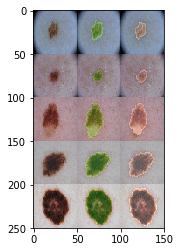

In [6]:
showSampleImages(5)

Image: ISIC_0012464.jpg --  size(2848, 4288, 3)
Image: ISIC_0014248.jpg --  size(2848, 4288, 3)
Image: ISIC_0013863.jpg --  size(2848, 4288, 3)
Image: ISIC_0013565.jpg --  size(2848, 4288, 3)
Image: ISIC_0013966.jpg --  size(2000, 3008, 3)


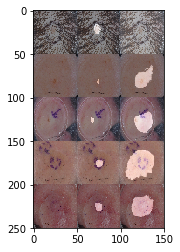

In [4]:
showSampleImagesFile(sorted_scores[:5,0])

Image: ISIC_0013321.jpg --  size(2848, 4288, 3)
Image: ISIC_0012742.jpg --  size(2000, 3008, 3)
Image: ISIC_0014525.jpg --  size(2848, 4288, 3)
Image: ISIC_0014688.jpg --  size(4398, 6648, 3)
Image: ISIC_0003056.jpg --  size(2848, 4288, 3)


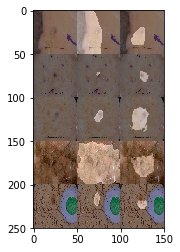

In [5]:
showSampleImagesFile(sorted_scores[5:10,0])

Image: ISIC_0016029.jpg --  size(2848, 4288, 3)
Image: ISIC_0015040.jpg --  size(4420, 6621, 3)
Image: ISIC_0016024.jpg --  size(2592, 3872, 3)
Image: ISIC_0000322.jpg --  size(576, 767, 3)
Image: ISIC_0010584.jpg --  size(768, 1024, 3)


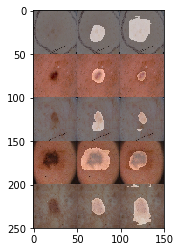

In [185]:
showSampleImagesFile(sorted_scores[55:60,0])

In [15]:
showImageSize(low_scores[:,0])

Image: ISIC_0013972.jpg --  size(2848, 4288, 3)
Image: ISIC_0012464.jpg --  size(2848, 4288, 3)
Image: ISIC_0013306.jpg --  size(2848, 4288, 3)
Image: ISIC_0013863.jpg --  size(2848, 4288, 3)
Image: ISIC_0013565.jpg --  size(2848, 4288, 3)
Image: ISIC_0013966.jpg --  size(2000, 3008, 3)
Image: ISIC_0013321.jpg --  size(2848, 4288, 3)
Image: ISIC_0012258.jpg --  size(2848, 4288, 3)
Image: ISIC_0003728.jpg --  size(2016, 3024, 3)
Image: ISIC_0015607.jpg --  size(4380, 6620, 3)
Image: ISIC_0011117.jpg --  size(768, 1024, 3)
Image: ISIC_0012706.jpg --  size(2000, 3008, 3)
Image: ISIC_0010847.jpg --  size(768, 1024, 3)
Image: ISIC_0010024.jpg --  size(768, 1024, 3)
Image: ISIC_0014525.jpg --  size(2848, 4288, 3)
Image: ISIC_0012940.jpg --  size(2592, 3872, 3)
Image: ISIC_0015969.jpg --  size(2000, 3008, 3)
Image: ISIC_0013721.jpg --  size(2000, 3008, 3)
Image: ISIC_0012749.jpg --  size(2000, 3008, 3)
Image: ISIC_0012742.jpg --  size(2000, 3008, 3)
Image: ISIC_0016024.jpg --  size(2592, 3872

In [6]:
low_scores[low_scores[:,1].astype(float)<0.1]

array([['ISIC_0012464.jpg', '0.0012393741635605693'],
       ['ISIC_0014248.jpg', '0.051027506589889526'],
       ['ISIC_0013863.jpg', '0.05774134770035744'],
       ['ISIC_0013565.jpg', '0.07529060542583466']], dtype='<U21')

In [7]:
SaveSampleImagesFile(low_scores)

ISIC_0012464.jpg
ISIC_0013321.jpg
ISIC_0014248.jpg
ISIC_0012742.jpg
ISIC_0013863.jpg
ISIC_0014525.jpg
ISIC_0013565.jpg
ISIC_0014688.jpg
ISIC_0013966.jpg
ISIC_0003056.jpg
ISIC_0012856.jpg
ISIC_0013001.jpg
ISIC_0012487.jpg
ISIC_0010024.jpg
ISIC_0011117.jpg
ISIC_0012786.jpg
ISIC_0013306.jpg
ISIC_0012706.jpg
ISIC_0001306.jpg
ISIC_0014526.jpg
ISIC_0014419.jpg
ISIC_0012705.jpg
ISIC_0012518.jpg
ISIC_0014476.jpg
ISIC_0012940.jpg
ISIC_0012969.jpg
ISIC_0012323.jpg
ISIC_0014580.jpg
ISIC_0012258.jpg
ISIC_0016012.jpg
ISIC_0014183.jpg
ISIC_0014632.jpg
ISIC_0015969.jpg
ISIC_0015211.jpg
ISIC_0011081.jpg
ISIC_0012749.jpg
ISIC_0016024.jpg
ISIC_0015607.jpg
ISIC_0013288.jpg
ISIC_0014985.jpg
ISIC_0000036.jpg
ISIC_0014190.jpg
ISIC_0012216.jpg
ISIC_0012678.jpg
ISIC_0014775.jpg
ISIC_0009951.jpg
ISIC_0013581.jpg
ISIC_0015008.jpg
ISIC_0012987.jpg
ISIC_0013178.jpg
ISIC_0013189.jpg
ISIC_0013065.jpg
ISIC_0010347.jpg
ISIC_0013970.jpg
ISIC_0014932.jpg
ISIC_0013839.jpg
ISIC_0001212.jpg
ISIC_0012372.jpg
ISIC_0012520.j

In [ ]:
african_e66lephant_output = model.output[:, 386]                          

last_conv_layer = model.get_layer('block5_conv3')                         

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]   

pooled_grads = K.mean(grads, axis=(0, 1, 2))                              

iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])           

pooled_grads_value, conv_layer_output_value = iterate([x])                

for i in range(512):                                                      
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]             

heatmap = np.mean(conv_layer_output_value, axis=-1)                       